In [1]:
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=RuntimeWarning)
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

In [ ]:
# concat the files based on the subject sequence number
# forward fills the whole df, then keeps the last row which contains every available data point
relevants = ['BPX', 'BMX', 'DEMO', 'BPQ', 'DIQ', 'SMQ', 'ALQ', 'PAQ']
files = os.listdir('download')
dfs = [pd.read_sas('download/' + file) for file in files]
df = pd.concat(dfs, ignore_index=True)
df = df.sort_values('SEQN')

# directly applying ffill drops the seqn column
# but using apply() and a lambda expression takes too long, this is a workaround
seqn = df['SEQN']
df = df.groupby('SEQN', as_index=False).ffill()
df.insert(loc=0, column='SEQN', value=seqn)
df = df.drop_duplicates(subset='SEQN', keep='last')

/var/folders/2q/0wssj_m1199_8dn42_d3j9lh0000gn/T/ipykernel_97215/1888757001.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(loc=0, column='SEQN', value=seqn)


In [3]:
# we should deal with string values in the df
# there're two columns which have string values: SMDUPCA and SMD100BR
# the first one is the cigarette product code, which we can drop
# and we'll encode the latter column with a basic scheme
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['SMD100BR'] = le.fit_transform(df['SMD100BR'])
df = df.drop(columns='SMDUPCA')

## Preliminary Data Analysis
For identifying key features, I will compare each measured metric (which i will refer as a column moving forward) of each file with different methods but the data contains lots of NaN values, and it'd be unnecessary to analyze a column that has 99% NaN values. So we'll start by checking the percentage of NaN values of a column, to see that how frequent that value is missing. And we'll see how much of the data we're eliminating by comparing different thresholds for this NaN percentage.

We could also check the total NaN percentage of a file and eliminate the files with too many NaNs, which would be more straightforward, but I want to leave as much as data as possible for training so I'll try to salvage columns with tolerable NaN values.

In [4]:
def nanPercentage(df):
    # calculate nan percents for each col in df
    nan_percents = pd.DataFrame(columns=['col', 'nan_percent'])
    for col in df.columns:
        nan_percents.loc[len(nan_percents.index)] = [col, (df[col].isna().sum() / df.shape[0]) * 100] 
    return nan_percents

def thrCols(target_df, target_col, thr = 98, reverse = 0):
    # return cols that have nan/corr percentages under a threshold
    if reverse:
        return target_df[target_df[target_col] > thr]
    else:
        return target_df[target_df[target_col] < thr]

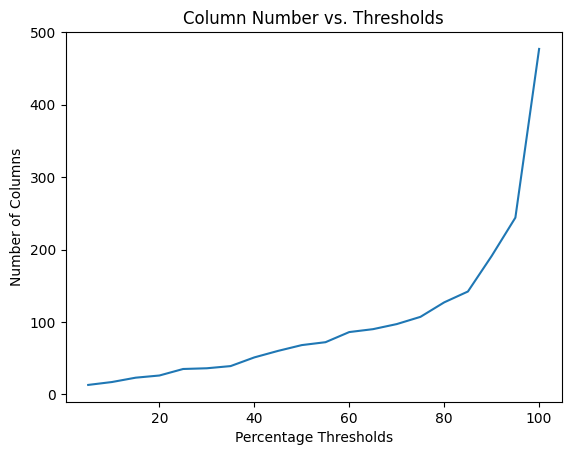

In [5]:
import matplotlib.pyplot as plt
nans = nanPercentage(df)
thresholds = range(100, 0, -5)
col_n = [thrCols(nans, 'nan_percent',thr).shape[0] for thr in thresholds] 

plt.plot(thresholds, col_n)

plt.xlabel("Percentage Thresholds")
plt.ylabel("Number of Columns")
plt.title("Column Number vs. Thresholds")
plt.show()

The graph above shows that choosing a low percentage of NaN values reduces the amount of data we have drastically. Hence, I'll choose a percentage threshold of 85 (i'll test other threshold values if i have the time) and fill-in the missing NaN values when preparing the dataset.

Now that we eliminated the first batch of NaNs. We start to make distinctions between useful, and not so useful columns by inspecting their correlations with respect to the blood pressure levels.

In [6]:
col_85 = thrCols(nans, 'nan_percent', thr=85, reverse = 1) # these columns will be dropped

systolic_cols = ['BPXSY1', 'BPXSY2', 'BPXSY3', 'BPXSY4']
diastolic_cols = ['BPXDI1', 'BPXDI2', 'BPXDI3', 'BPXDI4']
bpx_cols = systolic_cols + diastolic_cols